<a href="https://colab.research.google.com/github/KyawLinnKhant/MLmini/blob/main/kk23acu_ml_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏆 La Liga Matches Analysis & Prediction (2019-2025)
*EDA and Machine Learning Models for Match Outcome Prediction*


## 📋 Table of Contents
1. [Introduction & Objectives](#introduction)
2. [Data Loading & Initial Exploration](#data-loading)
3. [Exploratory Data Analysis](#eda)
4. [Feature Engineering](#feature-engineering)
5. [Machine Learning Models](#ml-models)
6. [Model Evaluation & Results](#evaluation)
7. [Predictions for Latest Season](#predictions)
8. [Conclusions & Insights](#conclusions)


## 🎯 Introduction & Objectives {#introduction}

This comprehensive analysis explores La Liga match data from 2019-2025, focusing on understanding team performance patterns and building predictive models for match outcomes. Our objectives include:

- **Comprehensive EDA**: Deep dive into team statistics, seasonal trends, and performance metrics
- **Feature Engineering**: Create meaningful features for prediction models
- **Model Building**: Implement multiple ML algorithms for match outcome prediction
- **Performance Analysis**: Evaluate model accuracy and provide actionable insights
- **Latest Season Focus**: Special attention to the most recent season's patterns and predictions



## 📊 Data Loading & Initial Exploration

In [ ]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.2 MB/s eta 0:00:00


In [ ]:
# ===============================
# Essential Libraries & Settings
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from IPython.display import display
from sklearn.metrics import confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score
)
import xgboost as xgb

# TensorFlow / Keras for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

# Keras Tuner
from kerastuner.tuners import RandomSearch

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ===============================
# Load Dataset from KaggleHub
# ===============================
import kagglehub

path = kagglehub.dataset_download("marcelbiezunski/laliga-matches-dataset-2019-2025-fbref")
file_path = f"{path}/matches_full.csv"
df = pd.read_csv(file_path)

# Dataset Overview
print("Path to dataset files:", path)
print("\nDataset Overview")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"Teams: {df['team'].nunique()} unique teams")
print(f"Seasons: {sorted(df['season'].dropna().unique())}")

/tmp/ipython-input-2-4229607909.py:36: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Path to dataset files: /kaggle/input/laliga-matches-dataset-2019-2025-fbref

Dataset Overview
Shape: (4318, 29)
Columns: ['Unnamed: 0', 'date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation', 'opp formation', 'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'season', 'team']
Date Range: 2019-08-16 to 2025-03-02
Teams: 27 unique teams
Seasons: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


In [ ]:
# ===============================
# Data Quality Assessment
# ===============================
print("\nData Quality Report")
print("=" * 50)

# Missing data report
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

quality_report = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing %': missing_percentage
}).sort_values('Missing %', ascending=False)

# Filter for only missing entries
missing_table = quality_report[quality_report['Missing %'] > 0]
display(missing_table)  # Use display for better rendering in Jupyter/Colab

# ===============================
# Basic Key Statistics
# ===============================
key_stats = {
    "Total Matches": [len(df)],
    "Average Goals per Match": [round(df['gf'].mean(), 2)],
    "Average Attendance": [round(df['attendance'].mean(), 0)],
    "Most Common Result": [df['result'].value_counts().idxmax()]
}

stats_df = pd.DataFrame(key_stats)
display(stats_df)  # Clean summary as a table


Data Quality Report


,Missing Count,Missing %
notes,4318,100.000000
attendance,974,22.556739
referee,54,1.250579
dist,3,0.069477


,Total Matches,Average Goals per Match,Average Attendance,Most Common Result
0,4318,1.27,27865.0,W


## 🔍 Exploratory Data Analysis
### 📅 Temporal Analysis

(0.0, 1.0)

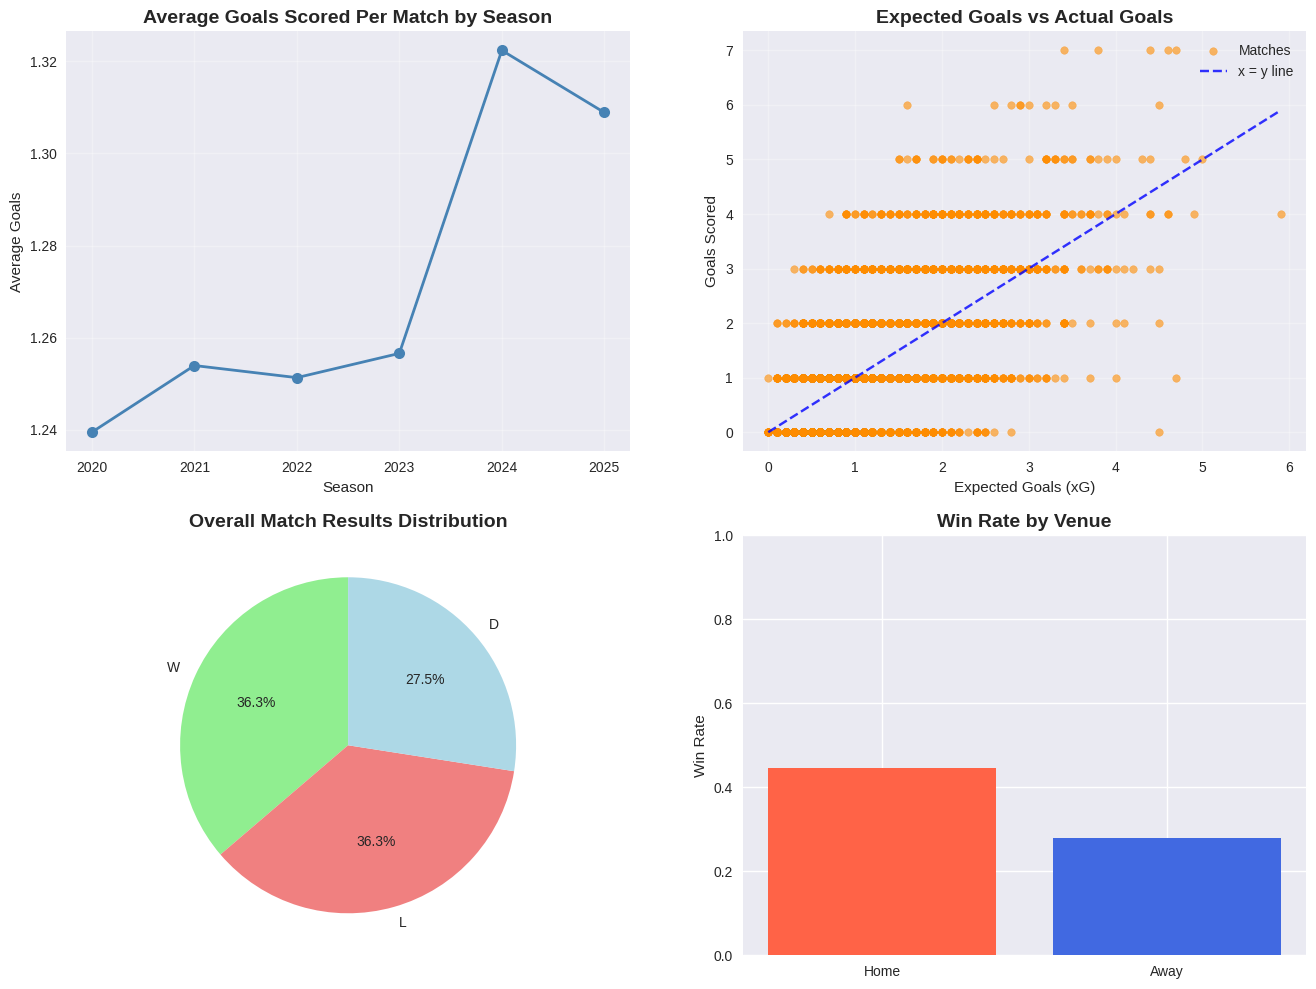

In [ ]:
# Goals and Performance Trends
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Goals scored over seasons
season_goals = df.groupby('season')['gf'].agg(['mean', 'sum', 'count']).reset_index()
axes[0, 0].plot(season_goals['season'], season_goals['mean'],
                marker='o', color='steelblue', linewidth=2, markersize=8)
axes[0, 0].set_title('Average Goals Scored Per Match by Season', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('Average Goals')
axes[0, 0].grid(True, alpha=0.3)

# 2. xG vs Actual Goals (different colors)
axes[0, 1].scatter(df['xg'], df['gf'], alpha=0.6, s=30, label='Matches', color='darkorange')
axes[0, 1].plot([0, df['xg'].max()], [0, df['xg'].max()],
                'b--', alpha=0.8, label='x = y line')
axes[0, 1].set_title('Expected Goals vs Actual Goals', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Expected Goals (xG)')
axes[0, 1].set_ylabel('Goals Scored')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Match results distribution
result_counts = df['result'].value_counts()
axes[1, 0].pie(result_counts.values, labels=result_counts.index,
               autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral', 'lightblue'])
axes[1, 0].set_title('Overall Match Results Distribution', fontsize=14, fontweight='bold')

# 4. Venue performance (force 'Home' first)
venue_performance = (
    df.groupby('venue')['result']
    .apply(lambda x: (x == 'W').mean())
    .reindex(['Home', 'Away'])  # Force order
    .reset_index()
)
venue_performance.columns = ['venue', 'win_rate']

axes[1, 1].bar(venue_performance['venue'], venue_performance['win_rate'],
              color=['tomato', 'royalblue'])
axes[1, 1].set_title('Win Rate by Venue', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Win Rate')
axes[1, 1].set_ylim(0, 1)

### 🏆 Team Performance Analysis

In [ ]:
# ===============================
# Team Performance Analysis
# ===============================
def calculate_team_stats(data):
    stats = data.groupby('team').agg({
        'result': lambda x: (x == 'W').sum(),  # Wins
        'gf': ['mean', 'sum'],                # Goals for
        'ga': ['mean', 'sum'],                # Goals against
        'xg': 'mean',                         # Expected goals
        'xga': 'mean',                        # Expected goals against
        'poss': 'mean',                       # Possession
        'sh': 'mean',                         # Shots
        'sot': 'mean',                        # Shots on target
        'attendance': 'mean'                  # Attendance
    }).round(2)

    stats.columns = ['wins', 'avg_gf', 'total_gf', 'avg_ga', 'total_ga',
                     'avg_xg', 'avg_xga', 'avg_poss', 'avg_shots', 'avg_sot', 'avg_attendance']

    # Add derived metrics
    stats['matches_played'] = data.groupby('team').size()
    stats['win_rate'] = (stats['wins'] / stats['matches_played']).round(3)
    stats['goal_difference'] = stats['total_gf'] - stats['total_ga']
    stats['efficiency'] = (stats['avg_gf'] / stats['avg_shots']).round(3)

    return stats.sort_values('win_rate', ascending=False)

# Calculate overall team stats
overall_stats = calculate_team_stats(df)
print("Top 10 Teams by Win Rate (Overall)")
display(overall_stats[['wins', 'matches_played', 'win_rate', 'goal_difference', 'avg_poss']].head(10))


Top 10 Teams by Win Rate (Overall)


,wins,matches_played,win_rate,goal_difference,avg_poss
team,,,,,
Real Madrid,146,216,0.676,263.0,59.82
Barcelona,142,216,0.657,256.0,65.16
Atletico Madrid,128,216,0.593,179.0,50.73
Girona,47,102,0.461,37.0,54.84
Real Sociedad,97,216,0.449,56.0,55.00
Villarreal,94,215,0.437,88.0,53.60
Sevilla,92,216,0.426,45.0,55.74
Real Betis,87,216,0.403,19.0,52.76
Athletic Club,84,216,0.389,63.0,49.55


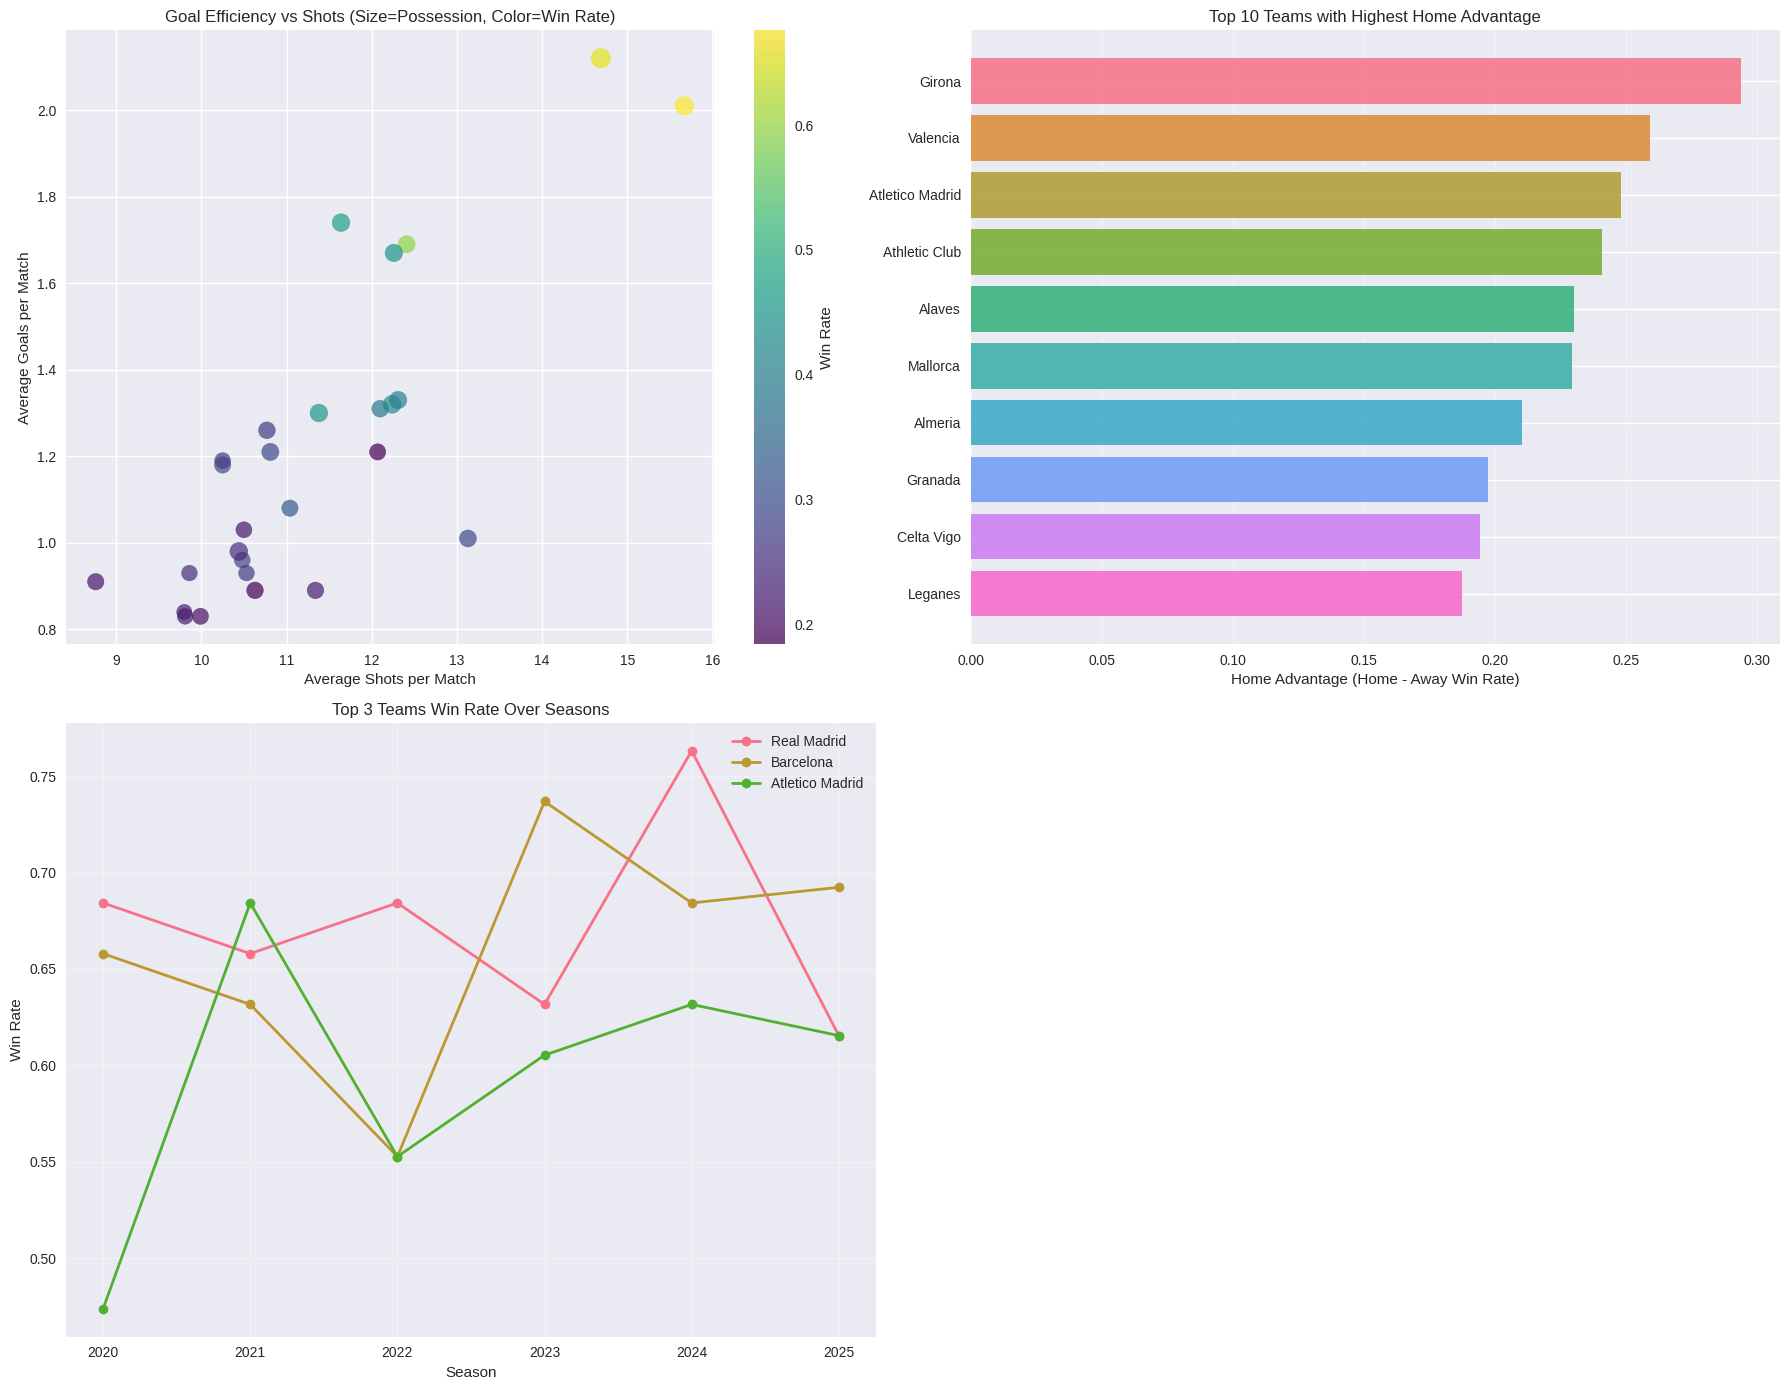

In [ ]:
# ===============================
# Advanced Performance Visualizations (Overall Stats)
# ===============================
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# --- Goal Efficiency vs Shots ---
scatter = axes[0, 0].scatter(
    overall_stats['avg_shots'],
    overall_stats['avg_gf'],
    s=overall_stats['avg_poss'] * 3,
    c=overall_stats['win_rate'],
    cmap='viridis',
    alpha=0.7
)
axes[0, 0].set_title('Goal Efficiency vs Shots (Size=Possession, Color=Win Rate)')
axes[0, 0].set_xlabel('Average Shots per Match')
axes[0, 0].set_ylabel('Average Goals per Match')
cbar = plt.colorbar(scatter, ax=axes[0, 0])
cbar.set_label('Win Rate')

# --- Home Advantage Bar Chart ---
home_away = df.groupby(['team', 'venue'])['result'].apply(lambda x: (x == 'W').mean()).unstack()

# Ensure correct order: Home first, Away second
home_away = home_away[['Home', 'Away']]
home_away.columns = ['home_winrate', 'away_winrate']
home_away['home_advantage'] = home_away['home_winrate'] - home_away['away_winrate']

# Top 10 teams with biggest home advantage
top_advantage = home_away.nlargest(10, 'home_advantage')

# Assign unique colors for each team
colors = sns.color_palette("husl", len(top_advantage))

# Plot horizontal bar chart
axes[0, 1].barh(
    y=top_advantage.index,
    width=top_advantage['home_advantage'],
    color=colors,
    alpha=0.85
)

axes[0, 1].set_xlabel('Home Advantage (Home - Away Win Rate)')
axes[0, 1].set_title('Top 10 Teams with Highest Home Advantage')
axes[0, 1].invert_yaxis()  # Best team on top
axes[0, 1].grid(axis='x', alpha=0.3)

# --- Seasonal Progression for Top 3 Teams (Overall Top 6 used) ---
top_teams = overall_stats.head(6).index
for team in top_teams[:3]:
    season_winrate = df[df['team'] == team].groupby('season')['result'].apply(lambda x: (x == 'W').mean())
    axes[1, 0].plot(season_winrate.index, season_winrate.values, marker='o', linewidth=2, label=team)

axes[1, 0].set_title('Top 3 Teams Win Rate Over Seasons')
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('Win Rate')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# --- Placeholder or Optional Plot for 4th quadrant ---
axes[1, 1].axis('off')  # You can optionally add a t-SNE / PCA plot or ROC-AUC curve here later

plt.tight_layout()
plt.show()

### 📈 Statistical Insights

Advanced Statistical Insights


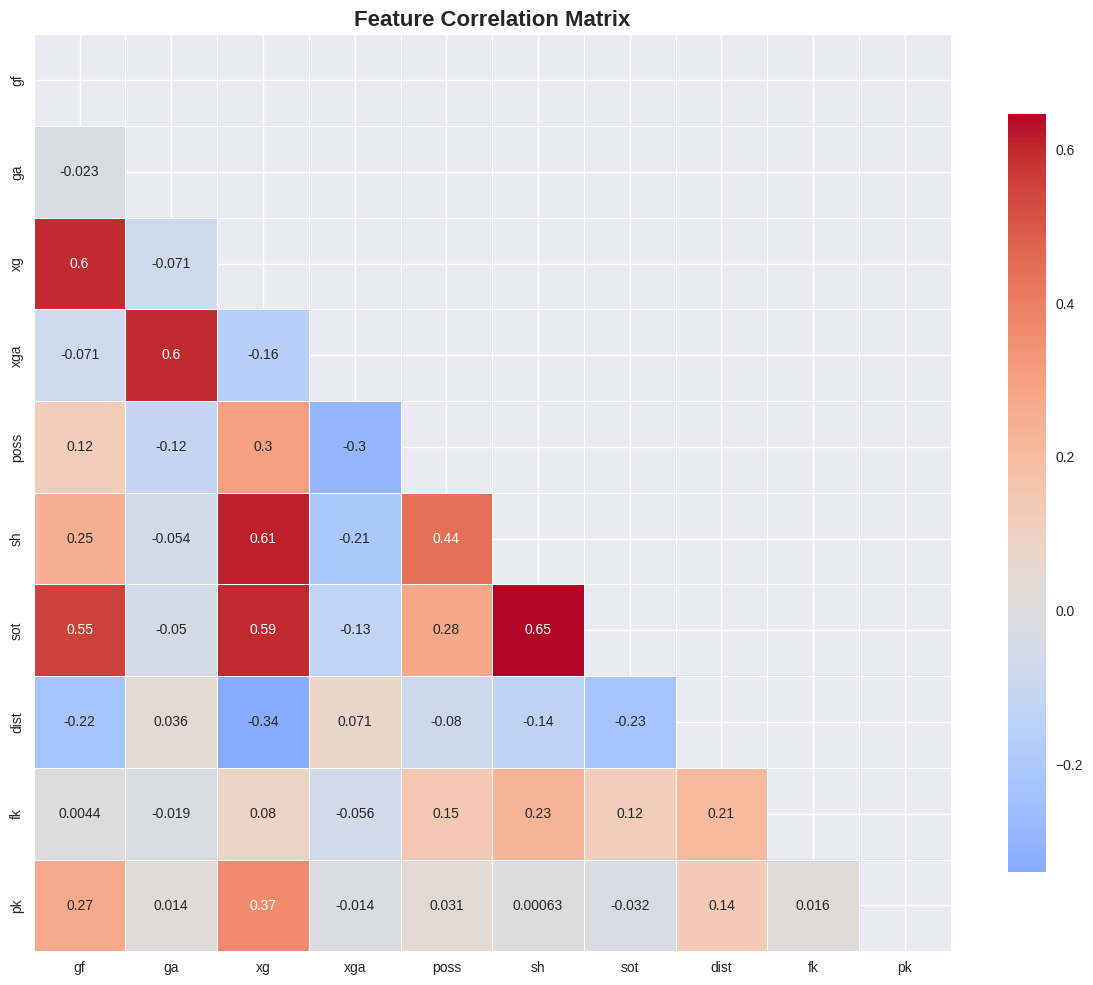


Key Statistical Findings
--------------------------------------------------
╒═════════════════════════════════════════╤════════════╕
│ Strongest correlation with goals scored │ xg (0.600) │
├─────────────────────────────────────────┼────────────┤
│ Average possession for winning teams    │ 51.2%      │
├─────────────────────────────────────────┼────────────┤
│ Average possession for losing teams     │ 48.8%      │
├─────────────────────────────────────────┼────────────┤
│ Home win rate                           │ 0.446      │
├─────────────────────────────────────────┼────────────┤
│ Away win rate                           │ 0.279      │
╘═════════════════════════════════════════╧════════════╛

Performance by Day of Week
--------------------------------------------------


,day_of_week,gf,result,attendance
0,Thursday,1.301,0.388,"23,918"
1,Wednesday,1.171,0.368,"29,564"
2,Saturday,1.259,0.368,"28,250"
3,Sunday,1.302,0.362,"30,250"
4,Friday,1.205,0.359,"22,576"
5,Monday,1.215,0.338,"20,005"
6,Tuesday,1.403,0.335,"28,329"


In [ ]:
from tabulate import tabulate

# ===============================
# Advanced Statistical Insights
# ===============================
print("Advanced Statistical Insights")
print("=" * 50)

# Correlation Analysis
numerical_cols = ['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'dist', 'fk', 'pk']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Key Statistical Findings
strongest_corr = correlation_matrix['gf'].drop('gf').abs().idxmax()
strongest_corr_value = correlation_matrix['gf'].drop('gf').abs().max()
win_poss = df[df['result'] == 'W']['poss'].mean()
lose_poss = df[df['result'] == 'L']['poss'].mean()
home_win_rate = (df[df['venue'] == 'Home']['result'] == 'W').mean()
away_win_rate = (df[df['venue'] == 'Away']['result'] == 'W').mean()

print("\nKey Statistical Findings")
print("-" * 50)

findings = [
    ["Strongest correlation with goals scored", f"{strongest_corr} ({strongest_corr_value:.3f})"],
    ["Average possession for winning teams", f"{win_poss:.1f}%"],
    ["Average possession for losing teams", f"{lose_poss:.1f}%"],
    ["Home win rate", f"{home_win_rate:.3f}"],
    ["Away win rate", f"{away_win_rate:.3f}"]
]

print(tabulate(findings, tablefmt="fancy_grid"))

# Ensure 'day_of_week' column exists
if 'day_of_week' not in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.day_name()

# Grouped Performance
day_performance = df.groupby('day_of_week').agg({
    'gf': 'mean',
    'result': lambda x: (x == 'W').mean(),
    'attendance': 'mean'
}).round(3).sort_values('result', ascending=False)

print("\nPerformance by Day of Week")
print("-" * 50)

# Reset index to show 'day_of_week' as column
day_performance_reset = day_performance.reset_index()

# Display compact table that fits in one line
from IPython.display import HTML

# Set wider display with styled HTML
display(HTML("<style>div.dataframe-container { width: 100% !important; }</style>"))

# Display the styled wider table
display(
    day_performance_reset.style.set_caption("Average Goals, Win Rate & Attendance by Day")
        .format({'gf': '{:.3f}', 'result': '{:.3f}', 'attendance': '{:,.0f}'})
        .set_table_styles([
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'th', 'props': [('font-size', '15px'), ('padding', '12px 18px')]},
            {'selector': 'td', 'props': [('font-size', '15px'), ('text-align', 'center'), ('padding', '12px 18px')]}
        ])
        .set_properties(**{'text-align': 'center'})
        .background_gradient(cmap='Blues', subset=['result'])
)

## ⚙️ Feature Engineering

In [ ]:
def create_features(data):
    """Generate advanced match and team-level features for ML models."""
    feature_df = data.copy()

    # --- Match-specific basic features ---
    feature_df['is_home'] = (feature_df['venue'] == 'Home').astype(int)
    feature_df['goal_difference'] = feature_df['gf'] - feature_df['ga']
    feature_df['total_goals'] = feature_df['gf'] + feature_df['ga']

    # --- Efficiency metrics ---
    feature_df['shot_accuracy'] = feature_df['sot'] / feature_df['sh'].replace(0, 1)
    feature_df['xg_efficiency'] = feature_df['gf'] / feature_df['xg'].replace(0, 1)
    feature_df['defensive_efficiency'] = feature_df['ga'] / feature_df['xga'].replace(0, 1)

    # --- Rolling averages (last 5 and 10 matches per team) ---
    feature_df = feature_df.sort_values(['team', 'date'])
    rolling_cols = ['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot']
    for col in rolling_cols:
        feature_df[f'{col}_rolling_5'] = (
            feature_df.groupby('team')[col]
            .rolling(5, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
        feature_df[f'{col}_rolling_10'] = (
            feature_df.groupby('team')[col]
            .rolling(10, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )

    # --- Team strength (historical overall averages) ---
    team_strength = feature_df.groupby('team').agg({
        'result': lambda x: (x == 'W').mean(),
        'gf': 'mean',
        'ga': 'mean',
        'xg': 'mean',
        'poss': 'mean'
    }).add_suffix('_team_avg')

    feature_df = feature_df.merge(team_strength, left_on='team', right_index=True)

    # --- Opponent strength ---
    opponent_strength = feature_df.groupby('opponent').agg({
        'result': lambda x: (x == 'L').mean(),  # Opponent loss rate
        'ga': 'mean',  # Goals opponent concedes
        'gf': 'mean'   # Goals opponent scores
    }).add_suffix('_vs_opponent')

    feature_df = feature_df.merge(opponent_strength, left_on='opponent', right_index=True, how='left')

    # --- Recent form (last 3 matches) ---
    result_map = {'W': 2, 'D': 1, 'L': 0}
    feature_df['result_numeric'] = feature_df['result'].map(result_map)
    feature_df['recent_form'] = (
        feature_df.groupby('team')['result_numeric']
        .rolling(3, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
    )
    feature_df = feature_df.drop(columns=['result_numeric'])

    # --- Season-level team stats ---
    season_stats = feature_df.groupby(['team', 'season']).agg({
        'result': lambda x: (x == 'W').mean(),
        'gf': 'mean',
        'ga': 'mean'
    }).add_suffix('_season')

    feature_df = feature_df.merge(season_stats, left_on=['team', 'season'], right_index=True)

    return feature_df

# Apply feature engineering
df_features = create_features(df)

# --- Summary ---
print("Feature Engineering Summary")
print("-" * 40)
print(f"Original columns        : {len(df.columns)}")
print(f"Enhanced columns        : {len(df_features.columns)}")
print(f"New features created    : {len(df_features.columns) - len(df.columns)}")

# List of new features
new_features = [col for col in df_features.columns if col not in df.columns]
print("\nNew Features Added:")
for i, feature in enumerate(new_features, 1):
    print(f"{i:2d}. {feature}")

Feature Engineering Summary
----------------------------------------
Original columns        : 30
Enhanced columns        : 62
New features created    : 32

New Features Added:
 1. is_home
 2. goal_difference
 3. total_goals
 4. shot_accuracy
 5. xg_efficiency
 6. defensive_efficiency
 7. gf_rolling_5
 8. gf_rolling_10
 9. ga_rolling_5
10. ga_rolling_10
11. xg_rolling_5
12. xg_rolling_10
13. xga_rolling_5
14. xga_rolling_10
15. poss_rolling_5
16. poss_rolling_10
17. sh_rolling_5
18. sh_rolling_10
19. sot_rolling_5
20. sot_rolling_10
21. result_team_avg
22. gf_team_avg
23. ga_team_avg
24. xg_team_avg
25. poss_team_avg
26. result_vs_opponent
27. ga_vs_opponent
28. gf_vs_opponent
29. recent_form
30. result_season
31. gf_season
32. ga_season


## 🤖 Machine Learning Models

In [ ]:
def prepare_ml_data_strict(data, target_col='result'):
    """Prepare features and strictly encode WDL as 0/1/2."""

    # --- Define strict mapping ---
    class_mapping = {'W': 0, 'D': 1, 'L': 2}

    # --- Selected feature columns ---
    feature_columns = [
        'is_home', 'gf_rolling_5', 'ga_rolling_5', 'xg_rolling_5', 'xga_rolling_5',
        'poss_rolling_5', 'sh_rolling_5', 'sot_rolling_5', 'shot_accuracy',
        'xg_efficiency', 'result_team_avg', 'gf_team_avg', 'ga_team_avg',
        'recent_form', 'result_season', 'gf_season', 'ga_season', 'poss'
    ]

    # --- Filter and encode ---
    ml_data = data[feature_columns + [target_col]].copy().dropna()
    ml_data[target_col + '_encoded'] = ml_data[target_col].map(class_mapping)

    X = ml_data[feature_columns]
    y = ml_data[target_col + '_encoded']

    return X, y, class_mapping, feature_columns

# Apply strict WDL encoding
X, y, class_mapping, feature_names = prepare_ml_data_strict(df_features)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Summary ---
print("ML Data Preparation Summary (W=0, D=1, L=2)")
print("-" * 40)
print(f"Feature columns        : {len(feature_names)}")
print(f"Samples after cleaning : {len(X)}")
print(f"Class mapping used     : {class_mapping}")
print(f"Class distribution     : {pd.Series(y).value_counts().to_dict()}")
print(f"Training samples       : {len(X_train)}")
print(f"Testing samples        : {len(X_test)}")

ML Data Preparation Summary (W=0, D=1, L=2)
----------------------------------------
Feature columns        : 18
Samples after cleaning : 4318
Class mapping used     : {'W': 0, 'D': 1, 'L': 2}
Class distribution     : {0: 1566, 2: 1566, 1: 1186}
Training samples       : 3454
Testing samples        : 864


Training Traditional Models

Training Bagging (Decision Tree)...
Bagging (Decision Tree) - Accuracy: 0.649, CV: 0.638 (±0.010)

Training XGBoost...
XGBoost - Accuracy: 0.638, CV: 0.646 (±0.016)

Training Logistic Regression...
Logistic Regression - Accuracy: 0.660, CV: 0.650 (±0.006)

Model Performance Summary:


,Bagging (Decision Tree),XGBoost,Logistic Regression
Accuracy,0.649000,0.638000,0.660000
Precision,0.636000,0.621000,0.637000
Recall,0.649000,0.638000,0.660000
F1-Score,0.637000,0.625000,0.641000
CV Mean,0.638000,0.646000,0.650000


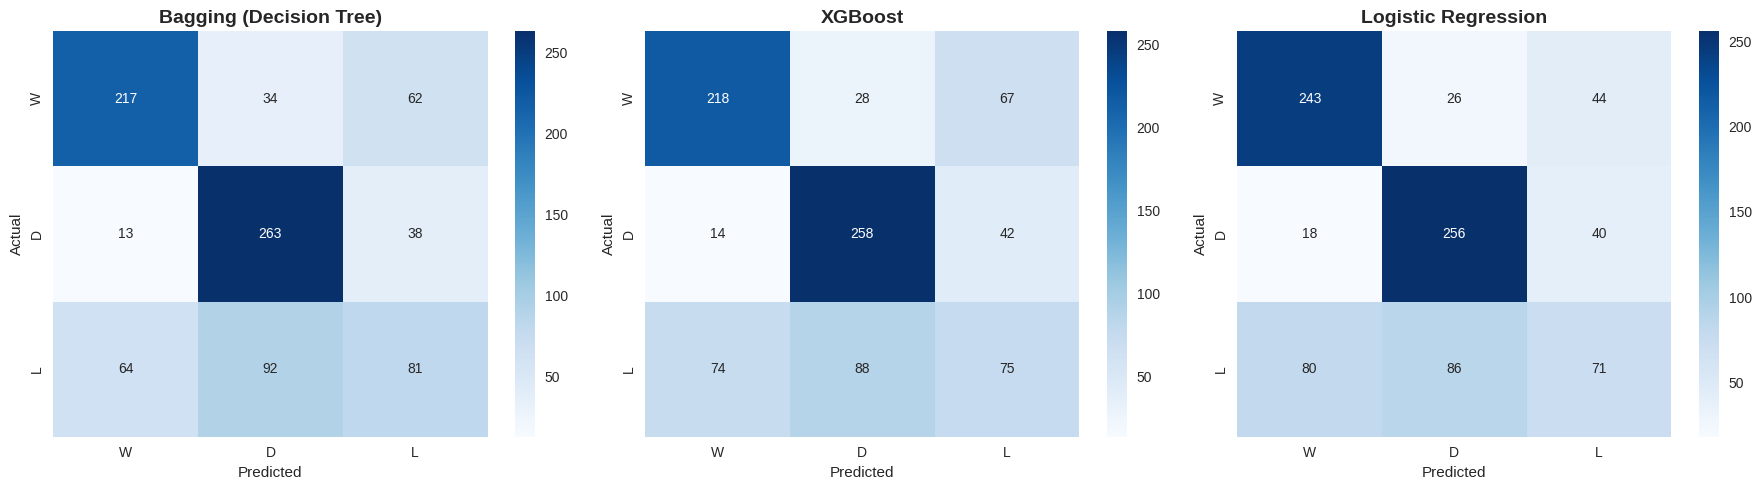

In [ ]:
# ============================================
# 🧪 Traditional Model Training & Evaluation
# ============================================
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix
)
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    'Bagging (Decision Tree)': BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=50,
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, max_depth=6),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

results = {}
model_objects = {}

print("Training Traditional Models")
print("=" * 60)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for models that need it
    if name == 'Logistic Regression':
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test

    model.fit(X_train_use, y_train)
    y_pred = model.predict(X_test_use)
    y_pred_proba = model.predict_proba(X_test_use)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='accuracy')

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    model_objects[name] = model

    print(f"{name} - Accuracy: {accuracy:.3f}, CV: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# Summary Table
results_df = pd.DataFrame({
    name: [m['accuracy'], m['precision'], m['recall'], m['f1'], m['cv_mean']]
    for name, m in results.items()
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV Mean'])

print("\nModel Performance Summary:")
display(
    results_df.round(3)
    .style.set_properties(**{'text-align': 'center'})
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center')]
    }])
)

# Force WDL label order
label_encoder = LabelEncoder()
label_encoder.fit(['W', 'D', 'L'])
wdl_indices = label_encoder.transform(['W', 'D', 'L'])

# Plot 1x3 confusion matrix grid for traditional models only
confusion_models = ['Bagging (Decision Tree)', 'XGBoost', 'Logistic Regression']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, name in enumerate(confusion_models):
    y_pred = results[name]['predictions']
    cm = confusion_matrix(y_test, y_pred, labels=wdl_indices)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['W', 'D', 'L'],
                yticklabels=['W', 'D', 'L'])

    axes[i].set_title(name, fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from kerastuner.tuners import RandomSearch
import pandas as pd
import numpy as np
from IPython.display import display, HTML

# =========================================
# Tuned MLP Neural Network with Wide L1/L2 Search + CV
# =========================================

tf.random.set_seed(42)

# Define model builder with wide-range L1/L2 regularization
def build_model(hp):
    l1 = hp.Float('l1_reg', 1e-5, 1.0, sampling='log')
    l2 = hp.Float('l2_reg', 1e-5, 1.0, sampling='log')
    reg = regularizers.l1_l2(l1=l1, l2=l2)

    model = Sequential()
    model.add(Dense(
        hp.Int('units_input', min_value=32, max_value=512, step=32),
        activation='relu',
        kernel_regularizer=reg,
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(Dropout(hp.Float('dropout_input', 0.1, 0.6, step=0.05)))

    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(
            hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
            activation='relu',
            kernel_regularizer=reg
        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.6, step=0.05)))

    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-1, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,  # as requested
    executions_per_trial=1,
    directory='mlp_tuner',
    project_name='la_liga_mlp'
)

tuner.search(X_train_scaled, y_train, epochs=30, validation_split=0.2, verbose=1)

# Retrieve best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Display best hyperparameters
hp_values = best_hps.values
hp_df = pd.DataFrame.from_dict(hp_values, orient='index', columns=['Best Value'])
hp_df.index.name = 'Hyperparameter'
hp_df.reset_index(inplace=True)

styled_table = hp_df.style.set_table_attributes("style='display:inline;border:1px solid black;border-collapse:collapse'")
styled_table = styled_table.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center',
    'font-size': '14px'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#002b36'), ('color', 'white'), ('padding', '6px'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('padding', '5px')]}
])

display(HTML("<h4>Best Hyperparameters (Auto-Tuned with L1/L2)</h4>"))
display(styled_table)

# Train final model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = best_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Predictions
y_pred_nn = best_model.predict(X_test_scaled)
y_pred_labels = tf.argmax(y_pred_nn, axis=1).numpy()

# Evaluation
accuracy_nn = accuracy_score(y_test, y_pred_labels)
precision_nn, recall_nn, f1_nn, _ = precision_recall_fscore_support(y_test, y_pred_labels, average='weighted')

# Cross-validation
cv_accuracies = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in kfold.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = tuner.hypermodel.build(best_hps)
    model.fit(X_tr, y_tr, epochs=50, batch_size=32,
              verbose=0, callbacks=[early_stop])

    val_preds = model.predict(X_val)
    val_labels = tf.argmax(val_preds, axis=1).numpy()
    acc = accuracy_score(y_val, val_labels)
    cv_accuracies.append(acc)

cv_mean = np.mean(cv_accuracies)
cv_std = np.std(cv_accuracies)

# Save results
results['MLP Neural Network (Tuned)'] = {
    'accuracy': accuracy_nn,
    'precision': precision_nn,
    'recall': recall_nn,
    'f1': f1_nn,
    'cv_mean': cv_mean,
    'cv_std': cv_std,
    'predictions': y_pred_labels,
    'probabilities': y_pred_nn
}
model_objects['MLP Neural Network (Tuned)'] = best_model

# Classification Report (WDL)
label_encoder = LabelEncoder()
label_encoder.fit(['W', 'D', 'L'])
ordered_labels = label_encoder.transform(['W', 'D', 'L'])

print("\nTuned MLP Classification Report (WDL Order):")
print(classification_report(
    y_test,
    y_pred_labels,
    target_names=['W', 'D', 'L'],
    labels=ordered_labels
))
print(f"\nCV Accuracy: {cv_mean:.3f} ± {cv_std:.3f}")

Trial 30 Complete [00h 00m 29s]
val_accuracy: 0.6671490669250488

Best val_accuracy So Far: 0.6903039216995239
Total elapsed time: 00h 12m 26s


,Hyperparameter,Best Value
0,l1_reg,0.000027
1,l2_reg,0.000207
2,units_input,480.000000
3,dropout_input,0.550000
4,num_layers,3.000000
5,units_0,192.000000
6,dropout_0,0.450000
7,learning_rate,0.004457
8,units_1,256.000000
9,dropout_1,0.400000


Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.5163 - loss: 1.4188 - val_accuracy: 0.6481 - val_loss: 1.0971
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6392 - loss: 1.1270 - val_accuracy: 0.6493 - val_loss: 1.0501
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6492 - loss: 1.0337 - val_accuracy: 0.6551 - val_loss: 0.9477
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6354 - loss: 0.9908 - val_accuracy: 0.6678 - val_loss: 0.9012
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6538 - loss: 0.9603 - val_accuracy: 0.6690 - val_loss: 0.8604
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6549 - loss: 0.9132 - val_accuracy: 0.6586 - val_loss: 0.8467
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6377 - loss: 0.8980 - val_accuracy: 0.6725 - val_loss: 0.8165
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6357 - loss: 0.8732 - val_accuracy: 0

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_interactive_accuracy_loss(history):
    epochs = list(range(1, len(history.history['accuracy']) + 1))

    fig = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy Over Epochs', 'Loss Over Epochs'))

    # Accuracy subplot
    fig.add_trace(go.Scatter(
        x=epochs, y=history.history['accuracy'],
        mode='lines+markers', name='Train Accuracy',
        line=dict(color='green')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=epochs, y=history.history['val_accuracy'],
        mode='lines+markers', name='Val Accuracy',
        line=dict(color='blue')
    ), row=1, col=1)

    # Loss subplot
    fig.add_trace(go.Scatter(
        x=epochs, y=history.history['loss'],
        mode='lines+markers', name='Train Loss',
        line=dict(color='red')
    ), row=1, col=2)

    fig.add_trace(go.Scatter(
        x=epochs, y=history.history['val_loss'],
        mode='lines+markers', name='Val Loss',
        line=dict(color='orange')
    ), row=1, col=2)

    fig.update_layout(
        title='Interactive MLP Training History',
        xaxis_title='Epoch',
        yaxis_title='Metric',
        template='plotly_white',
        legend=dict(x=0.5, y=-0.15, orientation='h'),
        height=500, width=1000
    )

    fig.show()

plot_interactive_accuracy_loss(history)

In [ ]:
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.signal import argrelextrema

def plot_annotated_loss_surface(history, sigma=0.8):
    # Extract loss and accuracy data from history
    epochs = np.arange(len(history.history['loss']))
    train_loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    train_acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])

    # Combine all data points
    all_epochs = np.concatenate([epochs, epochs])
    all_acc = np.concatenate([train_acc, val_acc])
    all_loss = np.concatenate([train_loss, val_loss])

    # Create interpolation grid
    grid_x, grid_y = np.meshgrid(
        np.linspace(all_epochs.min(), all_epochs.max(), 200),
        np.linspace(all_acc.min(), all_acc.max(), 200)
    )

    # Interpolate loss values over the grid
    grid_z = griddata(
        (all_epochs, all_acc),
        all_loss,
        (grid_x, grid_y),
        method='cubic'
    )

    # Smooth the surface
    grid_z_smooth = gaussian_filter(grid_z, sigma=sigma)

    # Locate global minimum
    min_idx = np.unravel_index(np.nanargmin(grid_z_smooth), grid_z_smooth.shape)

    # Approximate saddle point: where gradient is most "unstable"
    grad_x, grad_y = np.gradient(grid_z_smooth)
    saddle_idx = np.unravel_index(np.nanargmax(np.abs(grad_x + grad_y)), grid_z_smooth.shape)

    # Prepare surface plot
    fig = go.Figure(data=[go.Surface(
        z=grid_z_smooth,
        x=grid_x,
        y=grid_y,
        colorscale='Viridis',
        showscale=True,
        opacity=0.95
    )])

    # Add global minimum marker
    fig.add_trace(go.Scatter3d(
        x=[grid_x[min_idx]],
        y=[grid_y[min_idx]],
        z=[grid_z_smooth[min_idx] + 0.02],
        mode='markers+text',
        text=["Global Min"],
        textposition="top center",
        marker=dict(size=7, color='red', symbol='diamond')
    ))

    # Add saddle point marker
    fig.add_trace(go.Scatter3d(
        x=[grid_x[saddle_idx]],
        y=[grid_y[saddle_idx]],
        z=[grid_z_smooth[saddle_idx] + 0.02],
        mode='markers+text',
        text=["Saddle Point"],
        textposition="top center",
        marker=dict(size=7, color='black', symbol='cross')
    ))

    # Add local minima from training loss
    local_idxs = argrelextrema(train_loss, np.less)[0]
    for idx in local_idxs:
        fig.add_trace(go.Scatter3d(
            x=[epochs[idx]],
            y=[train_acc[idx]],
            z=[train_loss[idx] + 0.02],
            mode='markers+text',
            text=["Local Min"],
            textposition="top center",
            marker=dict(size=6, color='orange')
        ))

    # Layout settings
    fig.update_layout(
        title='Annotated 3D Loss Surface from Training History',
        scene=dict(
            xaxis_title='Epoch',
            yaxis_title='Accuracy',
            zaxis_title='Loss',
            camera=dict(eye=dict(x=1.4, y=1.5, z=0.9)),
        ),
        height=650,
        margin=dict(l=0, r=0, t=60, b=0)
    )

    fig.show()

# Call with your Keras history object
plot_annotated_loss_surface(history)

In [ ]:
# Append MLP result to results_df
results_df['MLP Neural Network (Tuned)'] = [
    accuracy_nn, precision_nn, recall_nn, f1_nn, cv_mean
]

print("\n Updated Model Comparison Including MLP:")
display(
    results_df.round(3)
    .style.set_properties(**{'text-align': 'center'})
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center')]
    }])
)


 Updated Model Comparison Including MLP:


,Bagging (Decision Tree),XGBoost,Logistic Regression,MLP Neural Network (Tuned)
Accuracy,0.649000,0.638000,0.660000,0.677000
Precision,0.636000,0.621000,0.637000,0.647000
Recall,0.649000,0.638000,0.660000,0.677000
F1-Score,0.637000,0.625000,0.641000,0.631000
CV Mean,0.638000,0.646000,0.650000,0.653000



Best Model: MLP Neural Network (Tuned)
Accuracy: 0.677

Feature importance is not available for model type: Sequential


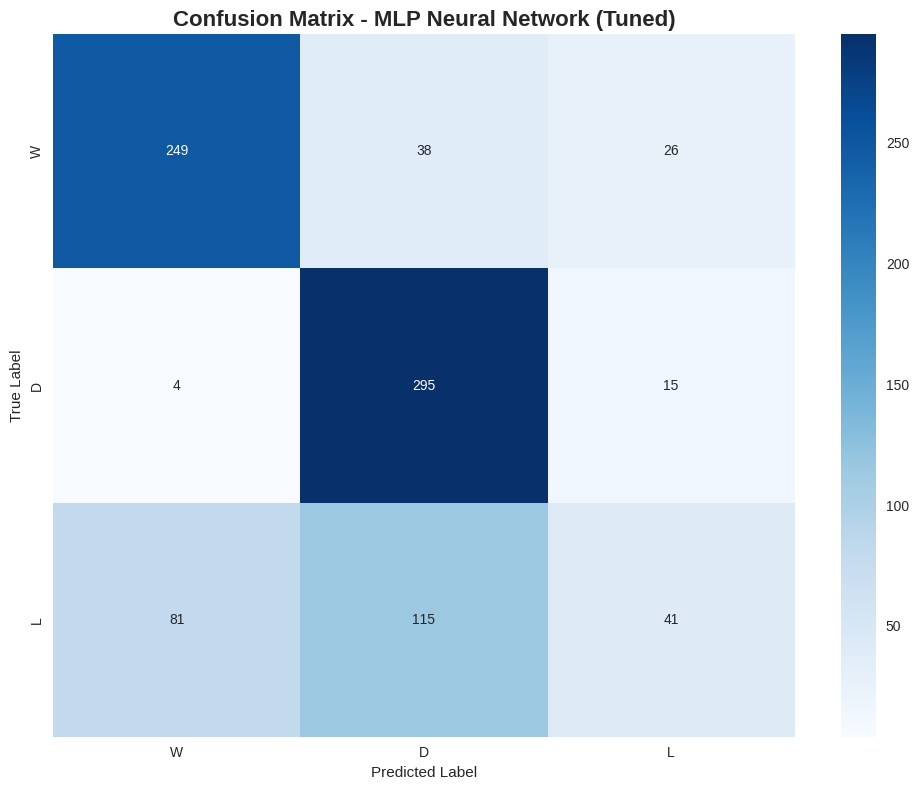


Detailed Classification Report - MLP Neural Network (Tuned):
              precision    recall  f1-score   support

           W       0.75      0.80      0.77       313
           D       0.66      0.94      0.77       314
           L       0.50      0.17      0.26       237

    accuracy                           0.68       864
   macro avg       0.63      0.64      0.60       864
weighted avg       0.65      0.68      0.63       864



In [ ]:
# ================================
# Feature Importance and Evaluation of Best Model
# ================================

# Identify best model by Accuracy
best_model_name = results_df.loc['Accuracy'].idxmax()
best_model = model_objects[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.3f}")

# Feature importance (tree-based models only)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

else:
    print(f"\nFeature importance is not available for model type: {type(best_model).__name__}")

# Force strict WDL label order
wdl_order = ['W', 'D', 'L']
wdl_indices = label_encoder.transform(wdl_order)

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(
    y_test,
    results[best_model_name]['predictions'],
    labels=wdl_indices
)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=wdl_order,
            yticklabels=wdl_order)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification report
print(f"\nDetailed Classification Report - {best_model_name}:")
print(classification_report(
    y_test,
    results[best_model_name]['predictions'],
    target_names=wdl_order,
    labels=wdl_indices
))

In [ ]:
import plotly.graph_objects as go
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# One-hot encode y_test
n_classes = 3
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = results[best_model_name]['probabilities']

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Create interactive figure
fig = go.Figure()

colors = cycle(['darkorange', 'green', 'steelblue'])
labels = label_encoder.inverse_transform([0, 1, 2])

# Add ROC curves for each class
for i, color in zip(range(n_classes), colors):
    fig.add_trace(go.Scatter(
        x=fpr[i],
        y=tpr[i],
        mode='lines',
        name=f'Class {labels[i]} (AUC = {roc_auc[i]:.2f})',
        line=dict(color=color, width=2)
    ))

# Add diagonal reference line
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random Guess',
    line=dict(dash='dash', color='gray')
))

fig.update_layout(
    title=f'Multi-class ROC Curve - {best_model_name}',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    template='plotly_white',
    width=800,
    height=600,
    legend=dict(x=0.7, y=0.1, bordercolor='black', borderwidth=1),
    margin=dict(l=40, r=40, t=60, b=40)
)

fig.show()

## 📈 Model Evaluation & Results

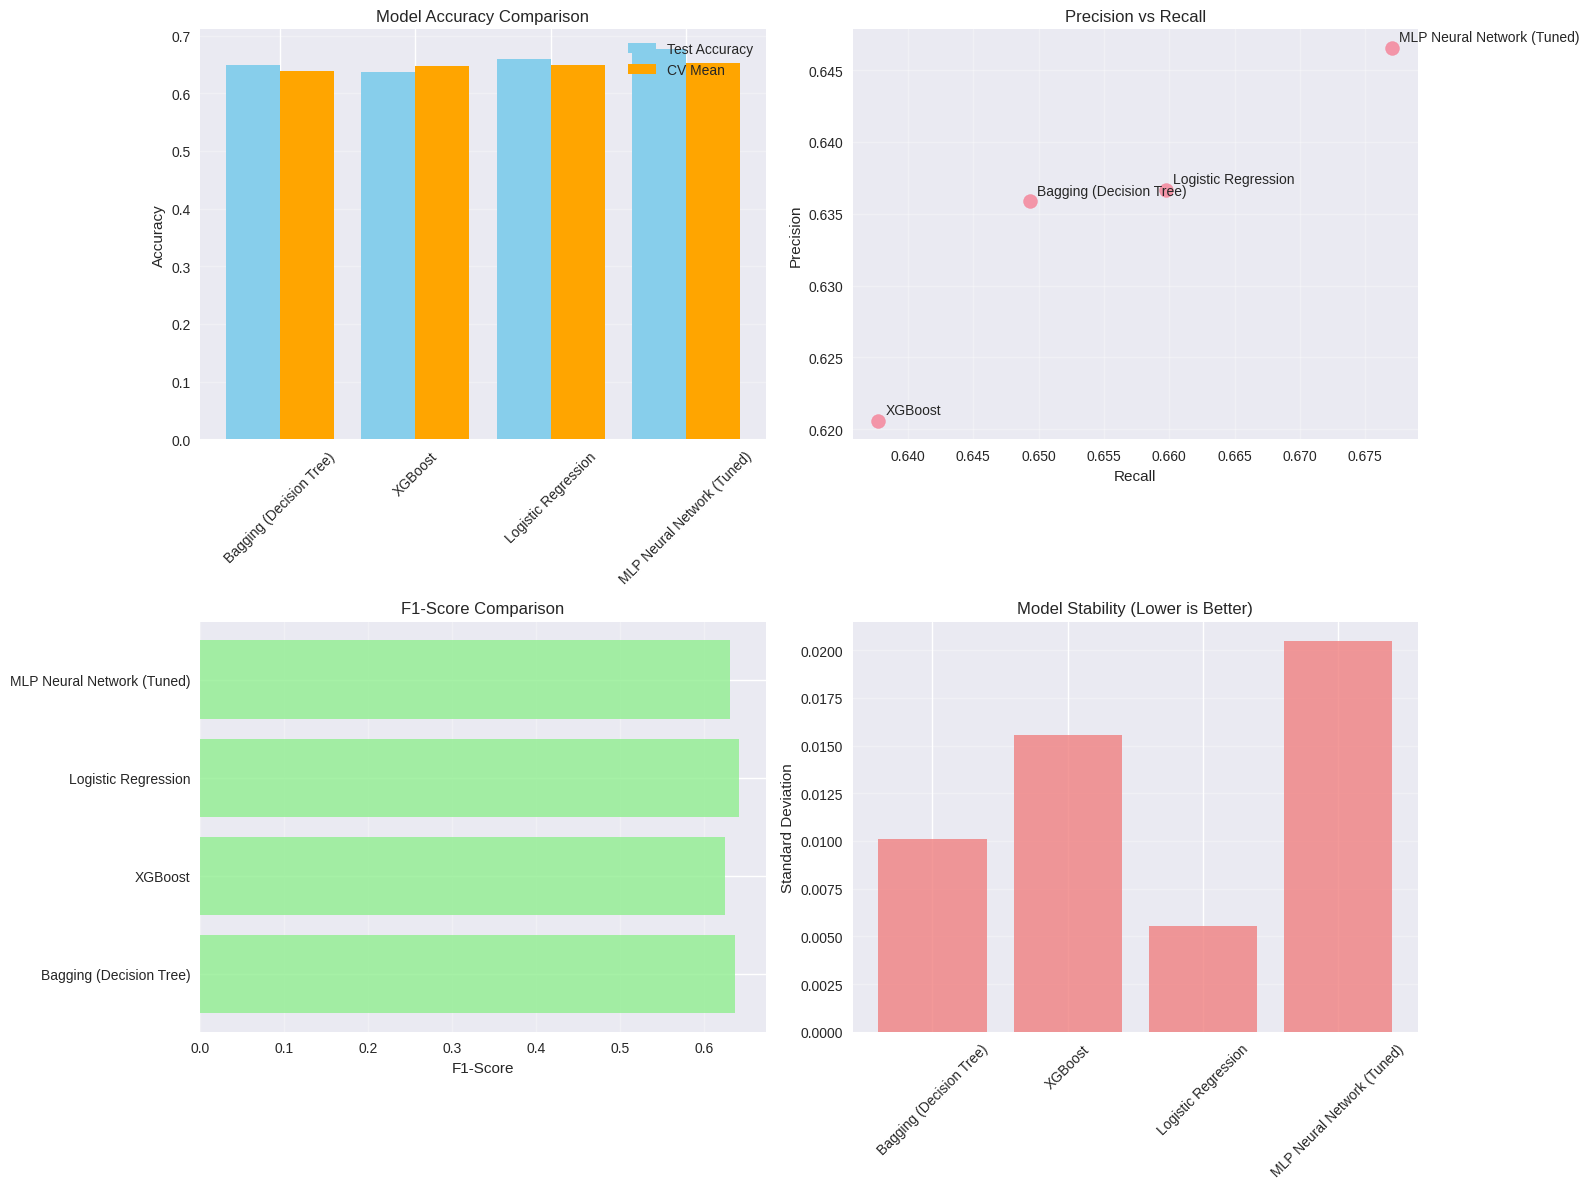

In [ ]:
# Advanced model evaluation
def evaluate_model_performance(models_results, y_true, label_encoder):
    """Comprehensive model evaluation"""

    evaluation_metrics = {}

    for model_name, results in models_results.items():
        y_pred = results['predictions']
        y_proba = results['probabilities']

        # Basic metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

        # Per-class metrics
        class_report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

        evaluation_metrics[model_name] = {
            'overall': {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1
            },
            'per_class': class_report
        }

    return evaluation_metrics

# Detailed evaluation
detailed_evaluation = evaluate_model_performance(results, y_test, label_encoder)

# Model comparison visualization
import numpy as np

# Model comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Basic metrics
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
precisions = [results[name]['precision'] for name in model_names]
recalls = [results[name]['recall'] for name in model_names]
f1_scores = [results[name]['f1'] for name in model_names]
cv_scores = [results[name].get('cv_mean') if results[name].get('cv_mean') is not None else np.nan for name in model_names]
cv_stds = [results[name].get('cv_std') if results[name].get('cv_std') is not None else np.nan for name in model_names]

# Accuracy + CV
axes[0,0].bar(np.arange(len(model_names)) - 0.2, accuracies, width=0.4, color='skyblue', label='Test Accuracy')
axes[0,0].bar(np.arange(len(model_names)) + 0.2, np.nan_to_num(cv_scores), width=0.4, color='orange', label='CV Mean')
axes[0,0].set_xticks(np.arange(len(model_names)))
axes[0,0].set_xticklabels(model_names, rotation=45)
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_title('Model Accuracy Comparison')
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

# Precision vs Recall
axes[0,1].scatter(recalls, precisions, s=100, alpha=0.7)
for i, name in enumerate(model_names):
    axes[0,1].annotate(name, (recalls[i], precisions[i]), xytext=(5, 5), textcoords='offset points', fontsize=10)
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision vs Recall')
axes[0,1].grid(True, alpha=0.3)

# F1-score
axes[1,0].barh(range(len(model_names)), f1_scores, color='lightgreen', alpha=0.8)
axes[1,0].set_yticks(range(len(model_names)))
axes[1,0].set_yticklabels(model_names)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score Comparison')
axes[1,0].grid(axis='x', alpha=0.3)

# CV std (skip missing)
valid_cv_std_indices = [i for i, val in enumerate(cv_stds) if not np.isnan(val)]
valid_cv_stds = [cv_stds[i] for i in valid_cv_std_indices]
valid_names = [model_names[i] for i in valid_cv_std_indices]

axes[1,1].bar(range(len(valid_names)), valid_cv_stds, color='lightcoral', alpha=0.8)
axes[1,1].set_xticks(range(len(valid_names)))
axes[1,1].set_xticklabels(valid_names, rotation=45)
axes[1,1].set_ylabel('Standard Deviation')
axes[1,1].set_title('Model Stability (Lower is Better)')
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Simulated dataset
np.random.seed(0)
X_plot = np.linspace(0, 1, 100).reshape(-1, 1)
X_train_sim = np.random.rand(15, 1)
y_train_sim = np.sin(2 * np.pi * X_train_sim).ravel() + np.random.normal(0, 0.1, X_train_sim.shape[0])
true_func = np.sin(2 * np.pi * X_plot).ravel()

# Degrees and corresponding annotations
degrees = [1, 4, 15]
descriptions = [
    "<span style='color:crimson'>(Underfit)</span>",
    "<span style='color:green'>(Optimal Bias-Variance)</span>",
    "<span style='color:royalblue'>(Overfit)</span>"
]

fig = go.Figure()

# Add prediction curves
for i, d in enumerate(degrees):
    model = make_pipeline(PolynomialFeatures(d), LinearRegression())
    model.fit(X_train_sim, y_train_sim)
    y_pred = model.predict(X_plot)

    fig.add_trace(go.Scatter(
        x=X_plot.ravel(),
        y=y_pred,
        mode='lines',
        name=f'Degree {d} Prediction',
        line=dict(width=3),
        visible=(i == 0)
    ))

# Add static components
fig.add_trace(go.Scatter(
    x=X_train_sim.ravel(),
    y=y_train_sim,
    mode='markers',
    name='Train Data',
    marker=dict(color='red', size=7),
    visible=True
))
fig.add_trace(go.Scatter(
    x=X_plot.ravel(),
    y=true_func,
    mode='lines',
    name='True Function',
    line=dict(dash='dash', color='black'),
    visible=True
))

# Slider steps with combined title
steps = []
for i, d in enumerate(degrees):
    vis = [False] * len(degrees) + [True, True]
    vis[i] = True
    steps.append(dict(
        method="update",
        args=[
            {"visible": vis},
            {"title": f"<b>Interactive Bias-Variance Tradeoff:</b> Degree {d} {descriptions[i]}"}
        ],
        label=f"Degree {d}"
    ))

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Model Complexity: "},
    pad={"t": 50},
    steps=steps
)]

# Initial layout
fig.update_layout(
    sliders=sliders,
    title=f"<b>Interactive Bias-Variance Tradeoff:</b> Degree 1 {descriptions[0]}",
    xaxis_title="x",
    yaxis_title="y",
    height=500,
    template="plotly_white"
)

fig.show()